#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, TimeSeriesSplit, cross_val_score    
from sklearn.metrics import mean_squared_error

In [2]:
# Импортируем данные, сразу переведем колонку datetime к типу дататайм и переведем в индекс
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0]) 

In [3]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


На входе имеем данные с 1 марта по 31 августа

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# ресемплинируем данные по одному часу
data = data.resample('1H').sum()

In [6]:
data_rolling = data.copy()

In [7]:
# скользящее среднее
data_rolling['rolling_mean'] = data_rolling.num_orders.rolling(24).mean()

In [8]:
# скользящее стандартное отклонение
data_rolling['std'] = data_rolling.num_orders.rolling(24).std()

In [9]:
data_rolling

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN
...,...,...,...
2018-08-31 19:00:00,136,167.541667,63.268908
2018-08-31 20:00:00,154,168.041667,63.105487
2018-08-31 21:00:00,159,166.416667,62.801908


## Анализ

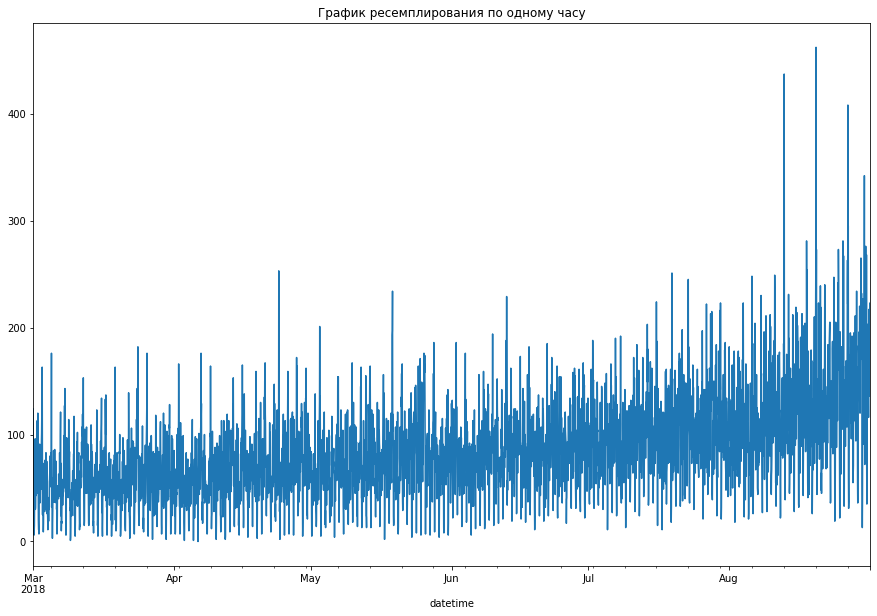

In [10]:
data_rolling.num_orders.plot()
plt.title('График ресемплирования по одному часу')
plt.show();

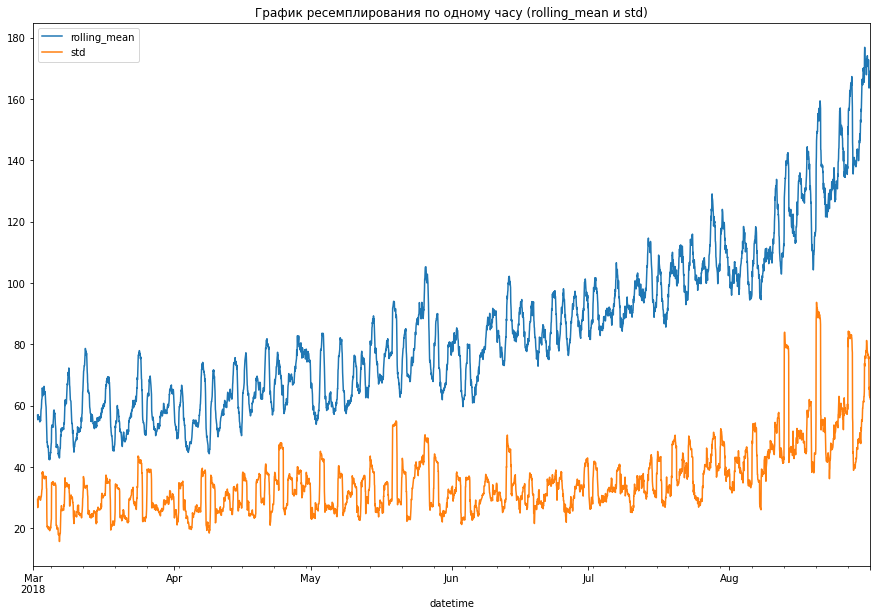

In [11]:
data_rolling.iloc[:,1:].plot()
plt.title('График ресемплирования по одному часу (rolling_mean и std)')
plt.show();

У данного графика меняется среднее значение, поэтому выборка не стационарна. В данных присутствуют шумы.

In [12]:
data_rolling.sort_index(inplace=True)

In [13]:
decomposed = seasonal_decompose(data_rolling.num_orders)

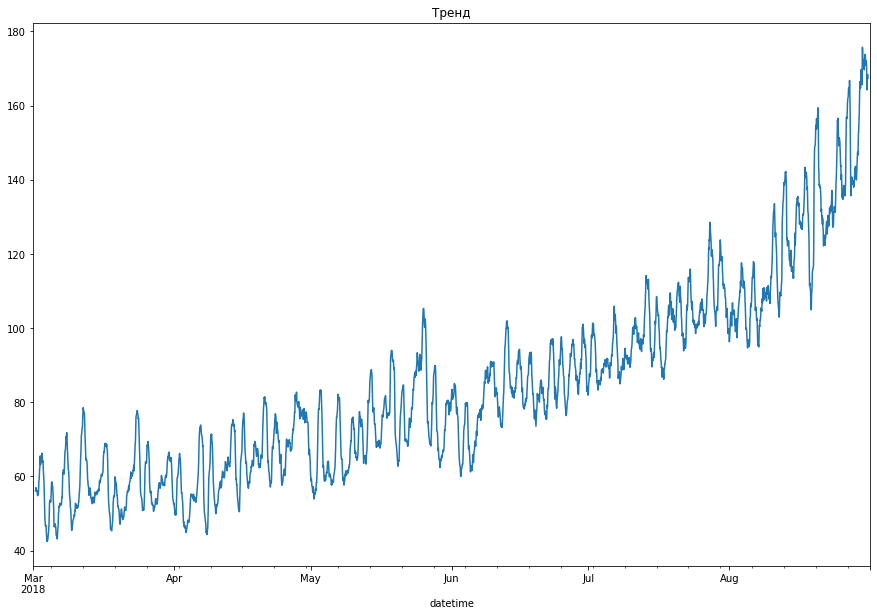

In [14]:
decomposed.trend.plot()
plt.title('Тренд')
plt.show();

Видим повышение компонены со временем

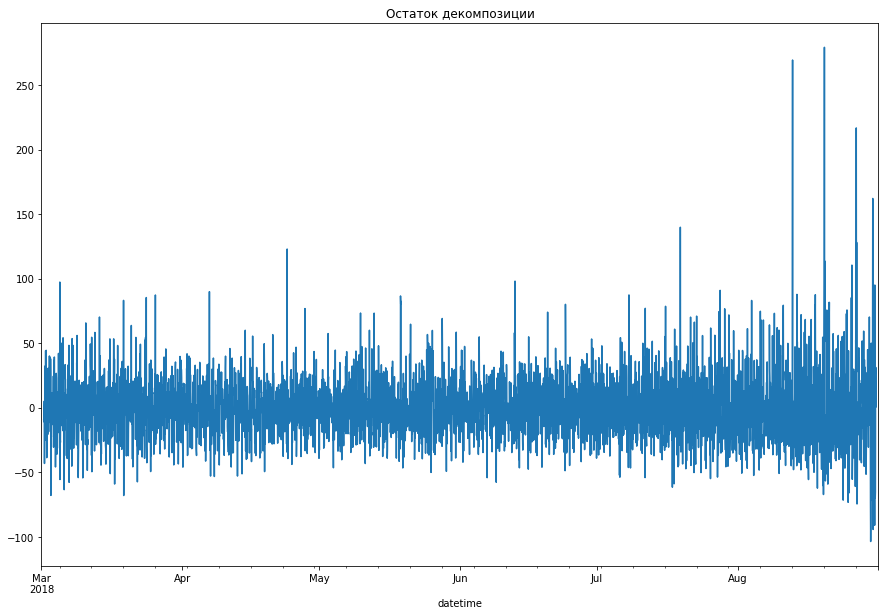

In [15]:
decomposed.resid.plot();
plt.title('Остаток декомпозиции')
plt.show();

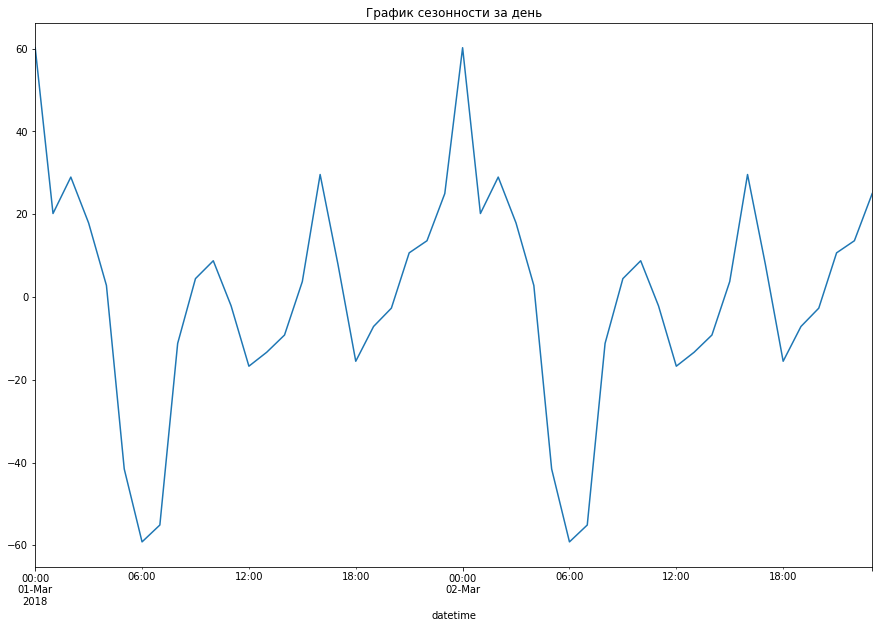

In [16]:
decomposed.seasonal['2018-03-01': '2018-03-02'].plot(ax=plt.gca());
plt.title('График сезонности за день')
plt.show();

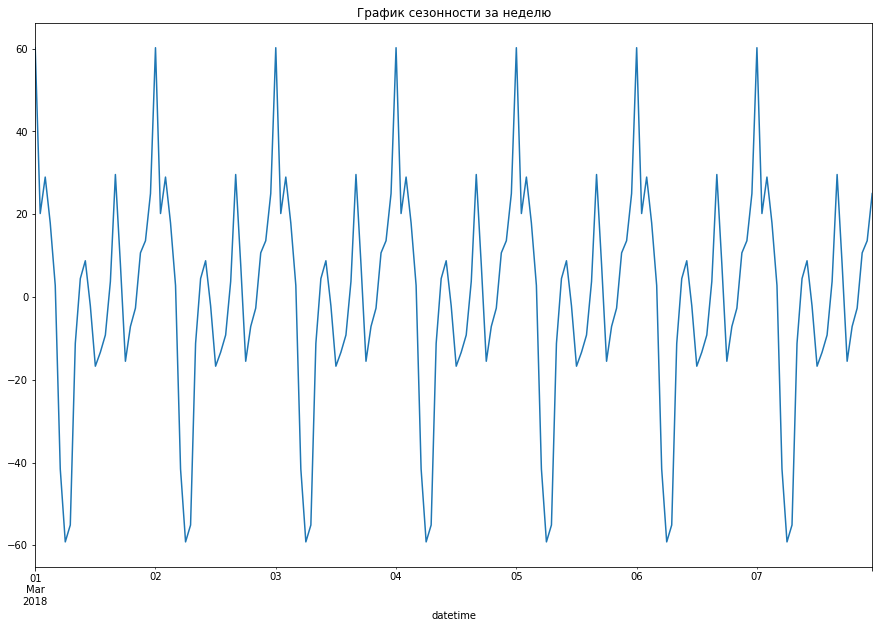

In [17]:
decomposed.seasonal['2018-03-01': '2018-03-07'].plot(ax=plt.gca());
plt.title('График сезонности за неделю')
plt.show();

Проверим разность временного ряда

In [18]:
data_shift = data - data.shift()

In [19]:
data_shift['rolling_mean'] = data_shift.num_orders.rolling(24).mean()

In [20]:
data_shift['std'] = data_shift.num_orders.rolling(24).std()

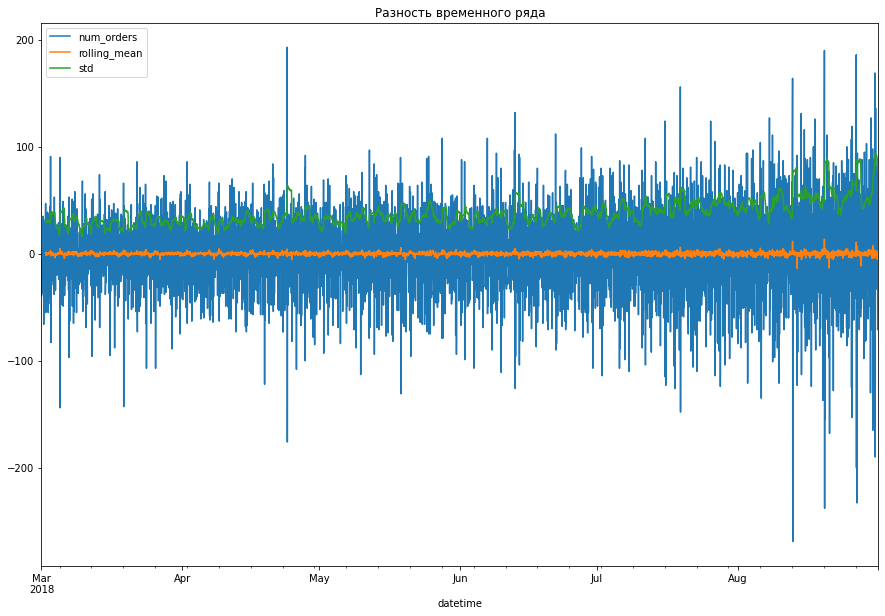

In [21]:
data_shift.plot()
plt.title('Разность временного ряда')
plt.show();

На входе мы получили данные по заказам такси с 1 марта по 31 августа 2018 года, ресемплинировали данные по одному часу, добавили скользящее среднее и скользящее стандартное отклонение, построили информативные графики. Выяснили, что выборка не стационарна, так как со временем меняется среднее значение, а еще в данных присутствуют шумы. Так же видно, что пик заказов выпадает на начало дня (ночью), к утру происходит спад, в течение дня заказы идут с периодической последовательностью.

## Обучение

In [22]:
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


Создадим новые признаки для построения моделей.

In [23]:
def make_features(data, max_lag, rolling_mean_size):

    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [24]:
make_features(data,24,20)

In [25]:
data = data.dropna()
data

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,50.90
2018-03-02 01:00:00,120,2,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,53.25
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,58.95
2018-03-02 03:00:00,64,2,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,62.10
2018-03-02 04:00:00,20,2,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,64.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,169.35
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,163.85
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,157.75


In [26]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [27]:
display(train.shape)
display(test.shape)

(3952, 28)

(440, 28)

In [28]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

### Модель линейной регрессии

In [29]:
model_lr = LinearRegression()

In [30]:
model_lr.fit(X_train, y_train);

In [32]:
tscv = TimeSeriesSplit(n_splits=5)

In [33]:
scores_list = cross_val_score(estimator=model_lr, 
                              X=X_train, 
                              y=y_train, 
                              cv=tscv,  
                              scoring='neg_mean_squared_error')

val_score = scores_list.mean()
val_score = np.sqrt(val_score*-1)   # Правильно?
print(f'Корень из квадратичной средней ошибки (RMSE) для модели лин. рег. составляет {round(val_score, 2)}')

Корень из квадратичной средней ошибки (RMSE) для модели лин. рег. составляет 27.42


### Модель RandomForestRegressor

In [38]:
model_rfr = RandomForestRegressor(random_state=42)

In [39]:
param_grid_rfr = {"max_depth": [1,10],"n_estimators":[10, 50, 100]}

In [40]:
grid_rfr = GridSearchCV(estimator=model_rfr, param_grid=param_grid_rfr, cv=tscv, scoring='neg_root_mean_squared_error')

In [41]:
%%time
grid_rfr.fit(X_train, y_train);

CPU times: user 20.7 s, sys: 61.7 ms, total: 20.7 s
Wall time: 20.7 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [1, 10], 'n_estimators': [10, 50, 100]},
             scoring='neg_root_mean_squared_error')

In [42]:
best_score_rfr = grid_rfr.best_score_*-1

In [43]:
print(f'Корень из квадратичной средней ошибки (RMSE) для модели RandomForestRegressor составляет {round(best_score_rfr, 2)}')

Корень из квадратичной средней ошибки (RMSE) для модели RandomForestRegressor составляет 26.04


In [44]:
print(f'Лучшие параметры модели RandomForestRegressor: {grid_rfr.best_params_}')

Лучшие параметры модели RandomForestRegressor: {'max_depth': 10, 'n_estimators': 100}


### Модель CatBoost

In [45]:
model_cb = CatBoostRegressor(loss_function='RMSE',random_state = 42)

In [46]:
param_cb = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}

In [47]:
grid_cb = GridSearchCV(estimator=model_cb, param_grid=param_cb, cv=tscv, scoring='neg_root_mean_squared_error')

In [48]:
%%time
grid_cb.fit(X_train, y_train)

In [49]:
best_score_cb = grid_cb.best_score_*-1

In [50]:
print(f'Корень из квадратичной средней ошибки (RMSE) для модели CatBoost составляет {round(best_score_cb, 2)}')

In [51]:
print(f'Лучшие параметры модели CatBoost: {grid_cb.best_params_}')

Лучшие параметры модели CatBoost: {'depth': 5, 'learning_rate': 0.1}

Лучшие параметры показала модель RandomForestRegressor RMSE составило 26.09

## Тестирование

Проведем тестирование на модели, которая показала лучшие результаты (RandomForestRegressor) #хотя я хотел показать все три.

### Модель линейной регрессии

In [52]:
#%%time
pred_lr = model_lr.predict(X_test)

In [53]:
rmse_lr = mean_squared_error(y_test, pred_lr)**0.5

In [54]:
print(f'Корень из квадратичной средней ошибки (RMSE) для модели линейной регрессии составляет {round(rmse_lr, 2)}')

### Модель RandomForestRegressor

In [55]:
%%time
pred_rfr = grid_rfr.best_estimator_.predict(X_test)

CPU times: user 16.6 ms, sys: 36 µs, total: 16.6 ms
Wall time: 16.1 ms


In [56]:
rmse_rfr = mean_squared_error(y_test, pred_rfr)**0.5

In [57]:
print(f'Корень из квадратичной средней ошибки (RMSE) для модели RandomForestRegressor составляет {round(rmse_rfr, 2)}')

Корень из квадратичной средней ошибки (RMSE) для модели RandomForestRegressor составляет 43.33


### Модель CatBoost

In [58]:
%%time
pred_cb = grid_cb.best_estimator_.predict(X_test)

In [59]:
rmse_cb = mean_squared_error(y_test, pred_cb)**0.5

In [60]:
#print(f'Корень из квадратичной средней ошибки (RMSE) для модели CatBoost составляет {round(rmse_cb, 2)}')

Лучше всего справилась модель RandomForestRegressor с результатом RMSE 43.33 на тестовой выборке.